## Natural Language Processing with Disaster Tweets
##### Authors: Ruth Ashford, Toby Petty and Li Jin
This report is based on a Kaggle competition: https://www.kaggle.com/c/nlp-getting-started/data

The aim is to classify tweets as being about a disaster or not. We are given a labelled training data set a long with a unlabelled test data set. 

In the report, we perform initial EDA on the data, cleaning and processing of the tweets text and evaluate the performance Naive Bayes, Neural Network and Logistic Regression models.

In [19]:
import numpy as np
import os
import pandas as pd
pd.set_option("display.max_colwidth", 500)

data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train_full = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train_full.shape}")
print(f"Test:  {test.shape}")

train_full.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Kaggle supplies the test set (without target labels), so we will submit our final predictions there to get the ultimate measure of model performance. We separate 20% of the training data as a validation set.

## Exploratory data analysis


Firstly we will check the number of samples that are labelled as disaster (1) and non-disaster (0)

In [20]:
train_label_summary = train.groupby('target').agg(Total = ('id','count'))
train_label_summary['Percentage'] = round(train_label_summary['Total'] / train.shape[0] * 100, 1)
train_label_summary

,Total,Percentage
target,,
0,3473,57.0
1,2617,43.0


This shows us that we have a fairly even split of disaster and non-disaster labelled samples. This is useful when training our model but tell us that this data set is not likely to be representative of the general population of tweets, we know in general there are far less than 43% of tweets that are about disasters.

### Keywords
Next we want to take a look at the keywords and how they relate to the target. The majority of tweets in our training data have a keyword associated with them, there is just 0.2% of samples that don't.

In [21]:
keyword_label_summary = train.groupby('keyword').agg(percentage_disaster_occurance = ('target', 'mean')).reset_index()

keyword_disaster_count = train[train['target'] == 1].groupby('keyword').agg(disaster_count = ('target', 'count')).reset_index()
keyword_not_disaster_count = train[train['target'] == 0].groupby('keyword').agg(not_disaster_count = ('target', 'count')).reset_index()

keyword_label_summary = keyword_label_summary.merge(keyword_disaster_count, how='left')
keyword_label_summary = keyword_label_summary.merge(keyword_not_disaster_count, how='left')

print(f' Percentage of tweets without a keyword: {round(1 - train.keyword.isna().sum() / train.shape[0] * 100 , 2)}%')

 Percentage of tweets without a keyword: 0.2%


Below are the words that come up most often in disaster tweets.

In [22]:
keyword_label_summary.sort_values('percentage_disaster_occurance', 
                                  ascending=False).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
62,debris,1.000000,30.0,NaN
70,derailment,1.000000,33.0,NaN
219,wreckage,1.000000,25.0,NaN
153,outbreak,0.965517,28.0,1.0
152,oil%20spill,0.964286,27.0,1.0
205,typhoon,0.962963,26.0,1.0
187,suicide%20bombing,0.962963,26.0,1.0
186,suicide%20bomber,0.956522,22.0,1.0
32,bombing,0.950000,19.0,1.0
147,nuclear%20disaster,0.928571,26.0,2.0


Below are the kewords that come up most often in non-disaster tweets. I can see that 'body%20bags' and body%20bag' is a duplicate and needs cleaning up. There are a lot of words here that I would associate with disasters, such as 'ruin', 'explode' and 'wrecked' but these are also words that could be used in a sentence when not describing a disaster.

In [23]:
keyword_label_summary.sort_values('percentage_disaster_occurance', 
                                  ascending=True).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
21,blew%20up,0.000000,NaN,25.0
2,aftershock,0.000000,NaN,25.0
29,body%20bags,0.026316,1.0,37.0
19,blazing,0.033333,1.0,29.0
25,bloody,0.034483,1.0,28.0
170,ruin,0.035714,1.0,27.0
27,body%20bag,0.041667,1.0,23.0
201,traumatised,0.043478,1.0,22.0
48,collide,0.043478,1.0,22.0
88,electrocute,0.043478,1.0,22.0


### Length of tweets
We want to understand if the length of the tweet differs for disaster tweets versus non-disaster tweets

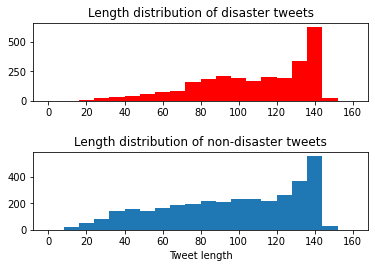

Average length of disaster tweets is 108 with standard deviation 29
Average length of non-disaster tweets is 96 with standard deviation 36


In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_length = train[train['target'] == 1]['text'].apply(lambda x: len(x))
non_disaster_length = train[train['target'] == 0]['text'].apply(lambda x: len(x))

axs[0].hist(x = disaster_length, color='red', bins=20, range = (0,160))
axs[0].set_title('Length distribution of disaster tweets')
axs[1].hist(x = non_disaster_length, bins=20, range = (0,160))
axs[1].set_title('Length distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet length')

plt.show()

print(f'Average length of disaster tweets is {round(disaster_length.mean())} ' \
 f'with standard deviation {round(disaster_length.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_length.mean())} ' \
 f'with standard deviation {round(non_disaster_length.std())}')


We can see that the do seem to be slightly longer, but not by a huge amount.

### Number of words
Similarily, we want to understand if there are any key differences in the number of words in the tweets.

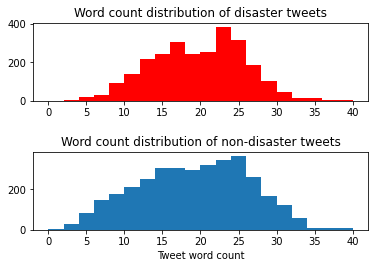

Average length of disaster tweets is 19 with standard deviation 6
Average length of non-disaster tweets is 19 with standard deviation 7


In [25]:
from nltk.tokenize import word_tokenize

fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_wc = train[train['target'] == 1]['text'].apply(lambda x: len(word_tokenize(x)))
non_disaster_wc = train[train['target'] == 0]['text'].apply(lambda x: len(word_tokenize(x)))

axs[0].hist(x = disaster_wc, color='red', bins=20, range = (0,40))
axs[0].set_title('Word count distribution of disaster tweets')
axs[1].hist(x = non_disaster_wc, bins=20, range = (0,40))
axs[1].set_title('Word count distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet word count')

plt.show()

print(f'Average length of disaster tweets is {round(disaster_wc.mean())} ' \
 f'with standard deviation {round(disaster_wc.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_wc.mean())} ' \
 f'with standard deviation {round(non_disaster_wc.std())}')

Again, no real difference here between disaster and non-disaster tweets.

### Location

Location data is provided for 65% of the samples. The location data seems to range from being as broad as a country, or as specific as the name of a restaurant.

In [26]:
print(f' Percentage of tweets without a location: ' + 
      f'{round((1 - train.location.isna().sum() / train.shape[0]) * 100 , 2)}%')

pd.DataFrame(train.location.unique())

 Percentage of tweets without a location: 66.55%


,0
0,NaN
1,UK
2,"Montgomery County, MD"
3,"Los Angeles, CA"
4,"Athens,Greece"
...,...
2751,"ÌÏT: 35.223347,-80.827834"
2752,ITALY
2753,Detroit Tigers Dugout
2754,Santiago de Cmpostela Galicia


### Baseline model

We use CountVectorizer and BernoulliNB to create a baseline model, and get benchmark score against the validation set.

Note that the target labels are binary outcomes, so they comrpise a Bernoulli distribution where  𝑝≈0.43 . Therefore accuracy is the chosen metric of performance, since there isn't a huge class imbalance.

### Training and validation data
We will reserve 20% of the training data set and a validation data set to test iterations of the model against.

In [27]:
# Shuffle the index in case there are patterns in the order of the training data:
np.random.seed(42)
shuffled_ix = list(train_full.index)
np.random.shuffle(shuffled_ix)
cutoff = int(len(shuffled_ix)*0.8)
train = train_full.loc[shuffled_ix[:cutoff]].copy()
validation = train_full.loc[shuffled_ix[cutoff:]].copy()

print(f'Train data set contains {train.shape[0]} samples')
print(f'Validation data set contains {validation.shape[0]} samples')

Train data set contains 6090 samples
Validation data set contains 1523 samples


In [28]:
train_data = train.text
train_labels = train.target
validation_data = validation.text
validation_labels = validation.target

In [29]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB

### Assessing the baseline model

Bernoulli distribution, p = 0.430
Mean accuracy on 5-fold cross validation = 0.802
Validation accuracy = 0.793


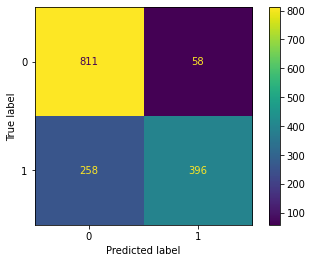

In [30]:
vec = CountVectorizer()
vec.fit(train_data)
train_vec = vec.transform(train_data)

print(f"Bernoulli distribution, p = {train_labels.mean():.3f}")

model = BernoulliNB()
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
validation_score = best_estimator.score(validation_vec, validation_labels)
print(f"Validation accuracy = {validation_score:.3f}")

preds = best_estimator.predict(validation_vec)

cm = plot_confusion_matrix(best_estimator, validation_vec, validation_labels)

The baseline gives us an accuracy on the validation data set of 0.793, we can see from the confusion matrix that there are a lot of false negatives.

In [31]:
def false_negatives(labels, preds, original_data, processed_data):
    df = pd.DataFrame()
    df['original_data'] = original_data
    df['processed_data'] = processed_data
    df['label'] = labels
    df['prediction'] = preds
    return df[(df.label == 1) & (df.prediction == 0)]

In [32]:
def false_positives(labels, preds, original_data, processed_data):
    df = pd.DataFrame()
    df['original_data'] = original_data
    df['processed_data'] = processed_data
    df['label'] = labels
    df['prediction'] = preds
    return df[(df.label == 0) & (df.prediction == 1)]

In [43]:
false_negatives(validation_labels, preds, validation_data, 
                validation_data)['processed_data'].to_frame()[:10]

,processed_data
1279,Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg
6883,@PyramidHead76 one good thing came out of watching the film. Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D
7138,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.
3156,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year
5207,@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.
3310,Sooo police dispatch said there was a person threatening to shoot up the Walmart on Rutherford &amp; they had to evacuate
3462,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died
2161,Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv
285,And so it begins.. day one of the snow apocalypse
4524,@Hurricane_Dolce no prob


In the false positives there are a lot of hyperlinks, punctuation and @ symbols that can be cleaned up.

## Model 1 - Naive Bayes

We will clean the data up and use stemming an lematization to see if we can improve upon the baseline Naive Bayes model.

In [35]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

def stem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def lem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmer.lemmatize(word, pos='n'))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r"(?:\@)\w+", ' ', text)
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~?!]+',' ',text)
    text = re.sub(r"[']+",'',text)
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    
    text=text.encode("ascii",errors="ignore").decode()

    return text

def clean_and_lem(text):
    return lem_sentence(clean_text(text))

def clean_and_stem(text):
    return stem_sentence(clean_text(text))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruthashford/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruthashford/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Clean tweets text
We clean the text to try to remove anything that adds noise, for example hyperlinks. 
In addition to this we've added Laplace smoothing to the model (alpha parameter)

In [36]:
vec = CountVectorizer(analyzer='word', preprocessor=clean_text)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.85)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
validation_score = best_estimator.score(validation_vec, validation_labels)
print(f"Validation accuracy = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.803
Validation accuracy = 0.803


Cleaning the data has improved the accuracy on the validation data set to 0.803

### Stemming
We use the Porter stemmer to normalize words in the tweets. A stemming algorithm reduces a word to it's root, for example “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

In [37]:
vec = CountVectorizer(analyzer='word', preprocessor=clean_and_stem)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.85)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
validation_score = best_estimator.score(validation_vec, validation_labels)
print(f"Validation accuracy = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.802
Validation accuracy = 0.802


Applying stemming to the data after cleaning it has reduced the accuracy of the model slightly, this may be due to overstemming where two words of different meaning are reduced to the same stem.

### Lemmatization
Lemmatization is similar to stemming but it converts a word to it's base form while also taking into account the context of the words. For example using lemmatization, 'caring' gets converted to 'care', whereas when using a stemmer, it will likely get converted to 'car'.

In [38]:
vec = CountVectorizer(analyzer='word', preprocessor=clean_and_lem)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
validation_score = best_estimator.score(validation_vec, validation_labels)
print(f"Validation accuracy = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.802
Validation accuracy = 0.807


Lemmatizing has been more successful and has increased the validation accuracy to 0.807

### Term Frequency - Inverse Document Frequency 
TFIDF is based on the same bag of words technique as Count Vectorizer but it considers how important the word is. It does this by determining how rare the word is by diving the number of times is appears in the document by the number of times it appears in any document.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(preprocessor=clean_and_lem, encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=11000, 
                       norm='l2'
                    )
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
validation_score = best_estimator.score(validation_vec, validation_labels)
print(f"Validation accuracy = {validation_score:.3f}")


Mean accuracy on 5-fold cross validation = 0.803
Validation accuracy = 0.806


In [40]:
false_negatives(validation_labels, preds, validation_data, 
                validation_data.apply(lambda x: clean_and_lem(x)))[['original_data', 'processed_data']][:20]

,original_data,processed_data
1279,Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg,burned dog find new home with young burn victim
6883,@PyramidHead76 one good thing came out of watching the film. Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D,one good thing came out of watching the film wa too traumatised to watch show so started halt amp catch fire on amazon d
7138,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.,hill hill mountain volcano of hell mountain hill hil
3156,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year,gon na call up tomorrow with the aul emergency dental appointment excuse just like the whole tooth falling out incident of last year
5207,@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.,it the closest structure to the hypo centre that wasnt completely obliterated
3310,Sooo police dispatch said there was a person threatening to shoot up the Walmart on Rutherford &amp; they had to evacuate,sooo police dispatch said there wa a person threatening to shoot up the walmart on rutherford amp they had to evacuate
3462,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died,oh yeah my ipod almost exploded last night i wa using it while charging and shit wa sparking akxbskdn almost died
2161,Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv,bigamist and his first wife are charged in the death of his second pregnant wife her child 8 her mothe
285,And so it begins.. day one of the snow apocalypse,and so it begin day one of the snow apocalypse
4524,@Hurricane_Dolce no prob,no prob


It's interesting to see a lot of the tweets here that were originally labelled as disasters don't seem to be about disasters, so when examining these it seems like our model may be correctly classifying them as non-disaster tweets. We'll get predictions for the test data set provided by Kaggle using this model and see how it performs.

### Assessing using the test data set


In [41]:
test_vec = vec.transform(test['text'])
test_preds = best_estimator.predict(test_vec)
nb_submission = pd.DataFrame({'id': test.id, 'target': test_preds})
#np.savetxt("naive_bayes_test_predictions.csv", test_preds, delimiter=",", header="target", 
      #     fmt="%i")
nb_submission.to_csv('naive_bayes_test_predictions.csv', index=False)

This submission gave us a Kaggle score of 0.79313

## Model 2 - Logistic Regression

## Model 3 - Neural Network

## Conclusion